<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/histone_ae_adam1024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 12.8MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# module auto reload
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [3]:
# copy modules
!cp -r '/content/drive/My Drive/dna_NN_theory/reading_dna_scripts' .
!ls reading_dna_scripts

download.py  load.py


In [4]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

from reading_dna_scripts.load import read_fasta

In [5]:
DIR = '/content/drive/My Drive/'
DATA_DIR = DIR + 'dna_NN_theory/histone/'
MODEL_DIR = DIR + 'dna_NN_theory/models/'
DATE = '_20210313'
SUFFIX = "ae_histone_adam1024"

In [6]:
file = DIR + 'H3.fasta'
sequences, labels = read_fasta(file)

14963 samples loaded


In [7]:
# split
SEED = 3264
test_size = 0.15
val_size = 0.15

split_options = dict(test_size=test_size, stratify=labels, random_state=SEED)
x_train_val, xtest, y_train_val, ytest = train_test_split(sequences, labels, **split_options)
# normalize val_size and update options
split_options.update(dict(test_size=val_size/(1-test_size), stratify=y_train_val))
xtrain, xval, ytrain, yval = train_test_split(x_train_val, y_train_val, **split_options)
del x_train_val, y_train_val
seq_len = len(xtrain[0])
print('train size:', len(xtrain))
print('val size: ', len(xval))
print('test size: ', len(xtest))
print("The length of the sequence is", seq_len)

train size: 10473
val size:  2245
test size:  2245
The length of the sequence is 500


In [8]:
word_size = 1
neucleotides = 'ACGT'
vocab = [''.join(p) for p in product(neucleotides, repeat=word_size)]
# word_to_idx = {word: i for i, word in enumerate(vocab)}
vocab_size = len(neucleotides)
print('vocab_size:', vocab_size)
# print("word_to_idx", word_to_idx)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 4


In [9]:
# the first two index of TextVectorization has been reserved to EOS and OOV
def index_preprocess(x):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, x_index

def ds_preprocess(x, y):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, y

def save_hist(hist, suf="_history.csv"):
  filename = DIR + 'dna_NN_theory/histone/' + SUFFIX + suf
  hist_df = pd.DataFrame(hist.history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)

def save_prediction():
  res = [ytrain, ytrain_pred, yval, yval_pred, ytest, ytest_pred]
  i = 0
  for ds in ['train', 'val', 'test']:
    filename = DIR + 'dna_NN_theory/histone/' + SUFFIX + "_" + ds + "_prediction.csv"
    df = pd.DataFrame()
    df[ds] = res[i]
    i += 1
    df[ds+'_pred'] = res[i]
    i += 1
    with open(filename, mode='w') as f:
      df.to_csv(f)
  
### ref: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
def plot_ROC(label, pred, title="ROC"):
  fpr, tpr, threshold = metrics.roc_curve(label, pred)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title(title)
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

### ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
def plot_recall_precision(label, pred, title="RP"):
  precision, recall, thresholds = metrics.precision_recall_curve(label, pred)
  no_skill = np.sum(label) / len(label)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='random')
  plt.plot(recall, precision, marker='.', label='model')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

In [10]:
BATCH_SIZE = 1024
xtrain_seq = tf.data.Dataset.from_tensor_slices(xtrain).map(index_preprocess).batch(BATCH_SIZE)
xval_seq = tf.data.Dataset.from_tensor_slices(xval).map(index_preprocess).batch(BATCH_SIZE)
xtest_seq = tf.data.Dataset.from_tensor_slices(xtest).map(index_preprocess).batch(BATCH_SIZE)

In [11]:
latent_size = 100

encoder = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
])

decoder = keras.Sequential([
    keras.layers.RepeatVector(seq_len, input_shape=[latent_size]),
    keras.layers.LSTM(latent_size, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(4, activation='softmax'))  # ACTG
])

recurrent_ae = keras.Sequential([encoder, decoder])
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100)               130400    
_________________________________________________________________
sequential_1 (Sequential)    (None, 500, 4)            80804     
Total params: 211,204
Trainable params: 211,204
Non-trainable params: 0
_________________________________________________________________


In [12]:
recurrent_ae.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics='accuracy')
es_cb = keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)
ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=4000, callbacks=[es_cb])

Epoch 1/4000
11/11 [==============================] - 43s 1s/step - loss: 1.3739 - accuracy: 0.3016 - val_loss: 1.3609 - val_accuracy: 0.3063
Epoch 2/4000
11/11 [==============================] - 10s 918ms/step - loss: 1.3602 - accuracy: 0.3109 - val_loss: 1.3589 - val_accuracy: 0.3147
Epoch 3/4000
11/11 [==============================] - 11s 918ms/step - loss: 1.3589 - accuracy: 0.3141 - val_loss: 1.3586 - val_accuracy: 0.3147
Epoch 4/4000
11/11 [==============================] - 11s 923ms/step - loss: 1.3587 - accuracy: 0.3155 - val_loss: 1.3585 - val_accuracy: 0.3165
Epoch 5/4000
11/11 [==============================] - 10s 917ms/step - loss: 1.3584 - accuracy: 0.3172 - val_loss: 1.3581 - val_accuracy: 0.3239
Epoch 6/4000
11/11 [==============================] - 11s 925ms/step - loss: 1.3576 - accuracy: 0.3240 - val_loss: 1.3558 - val_accuracy: 0.3320
Epoch 7/4000
11/11 [==============================] - 11s 922ms/step - loss: 1.3558 - accuracy: 0.3311 - val_loss: 1.3552 - val_accur

In [13]:
recurrent_ae.save(MODEL_DIR+SUFFIX+'_ae'+DATE+".h5")
save_hist(ae_hist, '_reconstruction_history.csv')

In [12]:
recurrent_ae = tf.keras.models.load_model(MODEL_DIR+SUFFIX+'_ae'+DATE+".h5")
encoder = recurrent_ae.layers[0]

In [13]:
xtrain_vec = encoder.predict(xtrain_seq)
xval_vec = encoder.predict(xval_seq)
xtest_vec = encoder.predict(xtest_seq)
print('The shape of xtrain/xval/xtest_seq is', xtrain_vec.shape, xval_vec.shape, xtest_vec.shape)

The shape of xtrain/xval/xtest_seq is (10473, 100) (2245, 100) (2245, 100)


In [14]:
model = keras.models.Sequential([
  keras.layers.Dense(128, activation="relu", input_shape=[latent_size]),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(64, activation="relu"),    
  keras.layers.Dropout(0.2),
  keras.layers.Dense(32, activation="relu"),  
  keras.layers.Dropout(0.2), 
  keras.layers.Dense(16, activation="relu"), 
  keras.layers.Dropout(0.2),   
  keras.layers.Dense(1, activation="sigmoid")                               
])
model.compile(keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [15]:
ytrain = np.array(ytrain)
yval = np.array(yval)
ytest = np.array(ytest)

In [17]:
es_cb = keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)
model_hist = model.fit(xtrain_vec, ytrain, validation_data=(xval_vec, yval), epochs=1500, callbacks=[es_cb])

Epoch 1/1500
328/328 [==============================] - 4s 3ms/step - loss: 0.6879 - accuracy: 0.6004 - val_loss: 0.6686 - val_accuracy: 0.7595
Epoch 2/1500
328/328 [==============================] - 1s 3ms/step - loss: 0.6664 - accuracy: 0.6903 - val_loss: 0.6305 - val_accuracy: 0.7675
Epoch 3/1500
328/328 [==============================] - 1s 3ms/step - loss: 0.6289 - accuracy: 0.7270 - val_loss: 0.5717 - val_accuracy: 0.7661
Epoch 4/1500
328/328 [==============================] - 1s 3ms/step - loss: 0.5787 - accuracy: 0.7419 - val_loss: 0.5253 - val_accuracy: 0.7693
Epoch 5/1500
328/328 [==============================] - 1s 3ms/step - loss: 0.5468 - accuracy: 0.7559 - val_loss: 0.5051 - val_accuracy: 0.7702
Epoch 6/1500
328/328 [==============================] - 1s 3ms/step - loss: 0.5317 - accuracy: 0.7563 - val_loss: 0.4968 - val_accuracy: 0.7719
Epoch 7/1500
328/328 [==============================] - 1s 3ms/step - loss: 0.5247 - accuracy: 0.7585 - val_loss: 0.4933 - val_accuracy:

In [18]:
def eval_model(model, x, true_label, ds_name="Training"):
  loss, acc = model.evaluate(x, true_label, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}".format(ds_name, np.round(loss, 4), np.round(acc, 4)))

eval_model(model, xtrain_vec, ytrain, "Training")
eval_model(model, xval_vec, yval,"Validation")
eval_model(model, xtest_vec, ytest,"Test")

Training Dataset: loss = 0.4768 and acccuracy = 0.7778
Validation Dataset: loss = 0.4763 and acccuracy = 0.7782
Test Dataset: loss = 0.4748 and acccuracy = 0.7826


In [19]:
# saving current model
model.save(MODEL_DIR+SUFFIX+'_nn'+DATE+".h5")
save_hist(model_hist, '_prediction_history.csv')

ytrain_pred = model.predict(xtrain_vec)
yval_pred = model.predict(xval_vec)
ytest_pred = model.predict(xtest_vec)
save_prediction()

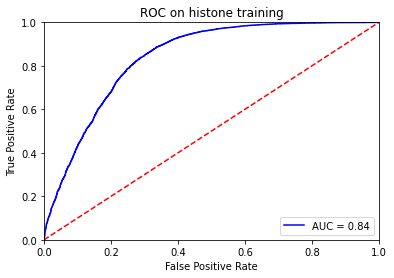

In [20]:
plot_ROC(ytrain,ytrain_pred, title='ROC on histone training')

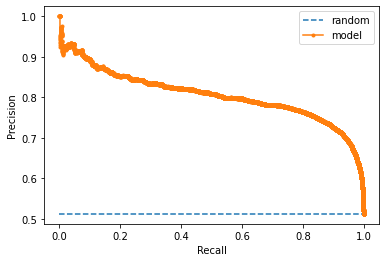

In [21]:
plot_recall_precision(ytrain, ytrain_pred, title='precision/recall on histone training')

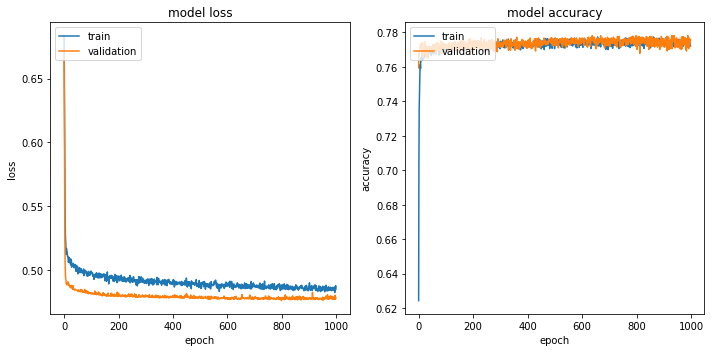

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(model_hist.history['loss'], label='training')
  ax1.plot(model_hist.history['val_loss'], label='validation')
  ax1.set_title('model loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(model_hist.history['accuracy'], label='training')
  ax2.plot(model_hist.history['val_accuracy'], label='validation')
  ax2.set_title('model accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()